In [3]:
import os
import glob

import numpy as np
import pandas as pd

# Don't install PyNIO into any environment that also has xarray
import xarray as xr

import metpy.calc as mpcalc
from metpy.units import units

from haversine import inverse_haversine, Unit, Direction

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import norm

#from uviz.utils.tools import find_TC_bbox
#from uviz.datashader_tools.utils import datashader_wrapper
from uviz.plotting.utils import basin_bboxes

In [4]:
tracks_dir = r"/gpfs/group/cmz5202/default/cnd5285/synth_events"
track_folders = glob.glob(os.path.join(tracks_dir, '*storm*'))
parent_folders = [os.path.join(folder, '28km') for folder in track_folders]
child_folders = [os.path.join(folder, '3km') for folder in track_folders]

In [5]:
# Native parent files
h2pn_files = [glob.glob(os.path.join(f, '*h2*[!nc_remap].nc')) for f in parent_folders]
h3pn_files = [glob.glob(os.path.join(f, '*h3*[!nc_remap].nc')) for f in parent_folders]
h4pn_files = [glob.glob(os.path.join(f, '*h4*[!nc_remap].nc')) for f in parent_folders]

# Regridded parent files
h2pr_files = [glob.glob(os.path.join(f, '*h2*.nc_remap.nc')) for f in parent_folders]
h3pr_files = [glob.glob(os.path.join(f, '*h3*.nc_remap.nc')) for f in parent_folders]
h4pr_files = [glob.glob(os.path.join(f, '*h4*.nc_remap.nc')) for f in parent_folders]

# Parent mesh file
# CAM mesh is the "ext" one, based on original model run. Other options are "ref" or "wat"
p_mesh_EXT = r"/gpfs/group/cmz5202/default/cnd5285/maps_and_grids/ne0np4natlanticext.ne30x4.g_scrip.nc"
p_mesh_REF = r"/gpfs/group/cmz5202/default/cnd5285/maps_and_grids/ne0np4natlanticref.ne30x4.g_scrip.nc"
p_mesh_WAT = r"/gpfs/group/cmz5202/default/cnd5285/maps_and_grids/ne0np4natlanticwat.ne30x4.g_scrip.nc"

# Native child files
h2cn_files = [glob.glob(os.path.join(f, '*h2*[!nc_remap].nc')) for f in child_folders]
h3cn_files = [glob.glob(os.path.join(f, '*h3*[!nc_remap].nc')) for f in child_folders]
h4cn_files = [glob.glob(os.path.join(f, '*h4*[!nc_remap].nc')) for f in child_folders]

# Regridded child files
h2cr_files = [glob.glob(os.path.join(f, '*h2*.nc_remap.nc')) for f in child_folders]
h3cr_files = [glob.glob(os.path.join(f, '*h3*.nc_remap.nc')) for f in child_folders]
h4cr_files = [glob.glob(os.path.join(f, '*h4*.nc_remap.nc')) for f in child_folders]

# Child mesh file
c_mesh = "/gpfs/group/cmz5202/default/cnd5285/MPAS_3km/x20.835586.florida.init.CAM.nc"

In [6]:
# # Reads in tracks, assigns to array of xarray datasets
# h2pn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h2pn_files]
# h3pn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h3pn_files]
# h4pn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h4pn_files]

# h2pr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h2pr_files]
# h3pr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h3pr_files]
# h4pr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h4pr_files]

# h2cn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h2cn_files]
# h3cn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h3cn_files]
# h4cn_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h4cn_files]

# h2cr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h2cr_files]
# h3cr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h3cr_files]
# h4cr_ds = [xr.open_mfdataset(folder, parallel=True) for folder in h4cr_files]

In [7]:
h4cr_ds = xr.open_mfdataset([file for file in h4cr_files[0]], parallel=True)

In [108]:
h4cr_ds

<xarray.Dataset>
Dimensions:       (lat: 1351, lon: 1851, time: 121, nbnd: 2, ilev: 33, lev: 32)
Coordinates:
  * lat           (lat) float64 10.0 10.02 10.04 10.06 ... 36.96 36.98 37.0
  * lon           (lon) float64 268.0 268.0 268.0 268.1 ... 305.0 305.0 305.0
  * ilev          (ilev) float64 4.5e+04 4.291e+04 4.085e+04 ... 703.5 249.0 0.0
  * lev           (lev) float64 4.395e+04 4.188e+04 3.984e+04 ... 476.3 124.5
  * time          (time) object 1989-08-22 00:00:00 ... 1989-08-27 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/25)
    lat_bnds      (time, lat, nbnd) float64 dask.array<chunksize=(24, 1351, 2), meta=np.ndarray>
    lon_bnds      (time, lon, nbnd) float64 dask.array<chunksize=(24, 1851, 2), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(24, 1351), meta=np.ndarray>
    area          (time, lat, lon) float64 dask.array<chunksize=(24, 1351, 1851), meta=np.ndarray>
    PRECC         (time, lat, lon) float32 dask.array<chunksize=(24, 1351, 1851), meta=np.ndarray>
    PRECT         (time, lat, lon) float32 dask.array<chunksize=(24, 1351, 1851), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(24, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(24,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:       CF-1.0
    source:            CAM
    case:              MPAS.VR3.REF.003.storm_0236
    logname:           zarzycki
    host:              cheyenne6
    initial_file:      /glade/p/univ/upsu0032/MPAS/3km_florida/x20.835586.flo...
    ...                ...
    remap_script:      ncremap
    remap_hostname:    cheyenne2
    remap_version:     5.0.3
    title:             Regridded version of MPAS.VR3.REF.901.cam.h4.1989-08-2...
    map_file:          /glade/u/home/zarzycki/scratch/map_mpasa3-60-florida_t...
    input_file:        /glade/p/univ/upsu0032/MPAS/output/VR28.NATL.REF.CAM5....

In [ ]:
class Statistics():
    def __init__(self, h2_ds, h3_ds, h4_ds, track_name):
        
        self.h2_ds = h2_ds
        self.h3_ds = h3_ds
        self.h4_ds = h4_ds
        self.track_name = track_name
        
    def precip_curves(self, bbox, var='PRECT', unit='in', savefig=False, **kwargs):
        """
        Optional kwargs:
        ---------------------
        rolling_windows :: list of rolling windows
        plot_kw :: plotting kwargs
        """
        
        rolling_kw = kwargs.get('rolling_kw', {'windows':[1, 3, 6, 12, 24, 36, 48, 72, 96, 120]})
        plot_kw = plot_kw.get('plot_kw', {'figsize':(7.5, 5), 'dpi':200, 
                                          'title':'Rolling Window of Maximum Accumulated Precipitation',
                                          'xlabel':'N-Hourly Rate',
                                          'ylabel':f'Accumulated Precipitation [{unit}]',
                                          'label_fs':9, 'title_fs':10, 'tick_fs':8})
        precip_ds = self.h4_ds
        lons, lats = bbox
        
        if unit == 'in':
            metpy_unit = 'inch/hour'
        elif unit == 'mm':
            metpy_unit = 'mm/hour'
        else:
            raise ValueError("Must supply 'in' or 'mm' for conversion.")
            
        # Subsets data by user-defined bounding box
        if 'lon' in precip_ds.dims:
            subset_precip = precip_ds[var].sel(lon=slice(lons[0], lons[1]), lat=slice(lats[0], lats[1]))
            subset_precip = subset_precip.isel(subset_precip.compute().argmax(dim=('lon', 'lat')))
        elif 'ncol' in precip_ds.dims:
            subset_precip = precip_ds[var].where((precip_ds.lon >= lons[0]) & (precip_ds.lon <= lons[1]) & 
                                                 (precip_ds.lat >= lats[0]) & (precip_ds.lat <= lats[1]))
            subset_precip = subset_precip.isel(ncol=subset_precip.compute().argmax(dim='time'))
        else:
            raise ValueError('Unsure if model is stuctured or regridded.')
            
        # Converts data to specified units
        subset_precip = subset_precip.metpy.convert_units(metpy_unit)
        
        # Creates DataFrame from array of values
        precip_arr = subset_precip.values
        precip_df = pd.DataFrame(precip_arr)
        
        # Creates new DataFrame for maximum sums
        sums_df = pd.DataFrame({f'sum_{i}': precip_df.rolling(i).sum().max() for i in rolling_kw['windows']}).T
        
        # Extracts into numpy array for faster calculation
        precip_sum_arr = sums_df.values
        
        # Takes maximum, 5th-, and 95th- percentiles
        max_precip = np.amax(precip_sum_arr, axis=1)
        percentile_5, median, percentile_95 = np.percentile(precip_sum_arr, [5, 50, 95], axis=1)
        
        # Plots output
        fig, ax = plt.subplots(figsize=plot_kw['figsize'], dpi=plot_kw['dpi'])
        x_axis = rolling_kw['windows']
        ax.plot(x_axis, max_precip, label='Maximim')
        ax.plot(x_axis, percentile_5, label='5th Percentile', ls='--')
        ax.plot(x_axis, median, label='Median', ls='--')
        ax.plot(x_axis, percentile_95, label='95th Percentile', ls='--')
        ax.set_title(plot_kw['title'], plot_kw['title_fs'])
        ax.set_xlabel(plot_kw['xlabel'], plot_kw['label_fs'])
        ax.set_ylabel(plot_kw['ylabel'], plot_kw['label_fs'])
        ax.set_xticks(x_axis, x_axis)
        ax.tick_params(axis='both', labelsize=['tick_fs'])
        plt.legend(fontsize=8)
        
        if savefig == True:
            print(f'Saving figure for {track_name}.')
            fig.savefig(f"../figs/new_tracks/{self.track_name}/precip_curves_{self.track_name}.png", 
                        bbox_inches='tight', dpi=plot_kw['dpi'], transparent=False)
            plt.close()
        elif savefig == False:
            plt.show()
        

In [5]:
# Reads in mesh files
#p_mesh_ds_EXT = xr.open_dataset(p_mesh_EXT)
p_mesh_ds_REF = xr.open_dataset(p_mesh_REF)
#p_mesh_ds_WAT = xr.open_dataset(p_mesh_WAT)

c_mesh_ds = xr.open_dataset(c_mesh)

In [8]:
h2cn_ds = xr.open_mfdataset([file for file in h2cn_files[0]], parallel=True)
h3cn_ds = xr.open_mfdataset([file for file in h3cn_files[0]], parallel=True)
h4cn_ds = xr.open_mfdataset([file for file in h4cn_files[0]], parallel=True)
#mpas_mesh_ds = Polymesh(c_mesh_ds, test_mpas_data, model='mpas')

In [91]:
h4cn_ds.dims

Frozen({'time': 121, 'ncol': 835586, 'ilev': 33, 'lev': 32, 'nbnd': 2})

In [11]:
ew, sn = basin_bboxes('miami')

In [12]:
h4cn_ds['PRECT'] = h4cn_ds['PRECT'].metpy.convert_units('inch/hour')

In [13]:
subset_ds = h4cn_ds['PRECT'].where((h4cn_ds.lon <= ew[1]) & (h4cn_ds.lon >= ew[0]) & 
                          (h4cn_ds.lat <= sn[1]) & (h4cn_ds.lat >= sn[0]), drop=True)

In [14]:
precip_ts = subset_ds.isel(ncol=subset_ds.compute().argmax(dim='time'))

In [27]:
precip_ts

<xarray.DataArray 'PRECT' (time: 121, ncol: 4759)>
<Quantity(dask.array<getitem, shape=(121, 4759), dtype=float32, chunksize=(24, 4759), chunktype=numpy.ndarray>, 'inch / hour')>
Coordinates:
  * time     (time) object 1989-08-22 00:00:00 ... 1989-08-27 00:00:00
Dimensions without coordinates: ncol
Attributes:
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

In [15]:
precip_arr = precip_ts.values

In [16]:
precip_df = pd.DataFrame(precip_arr)

In [17]:
x_axis = [1, 2, 3, 4, 5, 6, 9, 12, 18, 24, 36, 48, 72, 96, 120]
sums_df = pd.DataFrame({f'sum_{i}': precip_df.rolling(i).sum().max() for i in x_axis}).T

In [135]:
np.amax(sums_df.values, axis=1)

array([ 3.06412244,  8.34533286, 13.87689018, 21.06673753, 28.2504244 ,
       29.37981408, 29.70777104, 29.91907329, 30.10642207, 30.13541188])

In [23]:
max_precip

array([ 3.06412244,  5.74402642,  8.34533286, 10.49645019, 12.26964164,
       13.87689018, 18.15402544, 21.06673753, 25.11755773, 28.2504244 ,
       29.37981408, 29.70777104, 29.91907329, 30.10642207, 30.13541188])

In [18]:
precip_sum_arr = sums_df.values
max_precip = np.amax(precip_sum_arr, axis=1)
percentile_5, median, percentile_95 = np.percentile(precip_sum_arr, [5, 50, 95], axis=1)

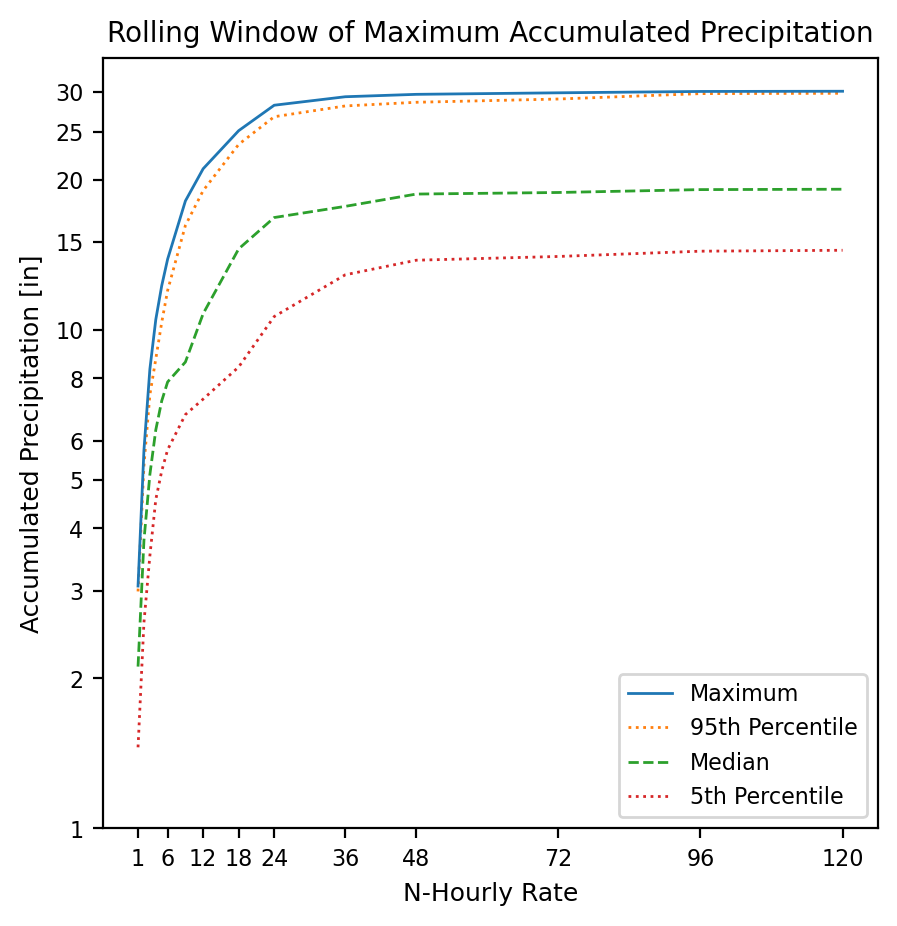

In [51]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.plot(x_axis, max_precip, label='Maximum', zorder=10, lw=1)
ax.plot(x_axis, percentile_95, ls=':', label='95th Percentile', lw=1)
ax.plot(x_axis, median, ls='--', label='Median', lw=1)
ax.plot(x_axis, percentile_5, ls=':', label='5th Percentile', lw=1)


ax.set_title('Rolling Window of Maximum Accumulated Precipitation', fontsize=10)
ax.set_xlabel('N-Hourly Rate', fontsize=9)
ax.set_ylabel('Accumulated Precipitation [in]', fontsize=9)
ax.set_yscale('log')
#ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

x_axis2 = [1, 6, 12, 18, 24, 36, 48, 72, 96, 120]
y_axis = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30]
ax.set_yticks(y_axis, y_axis)
ax.set_xticks(x_axis2, x_axis2)
ax.tick_params(axis='both', labelsize=8)
ax.minorticks_off()

plt.legend(fontsize=8)
plt.show()

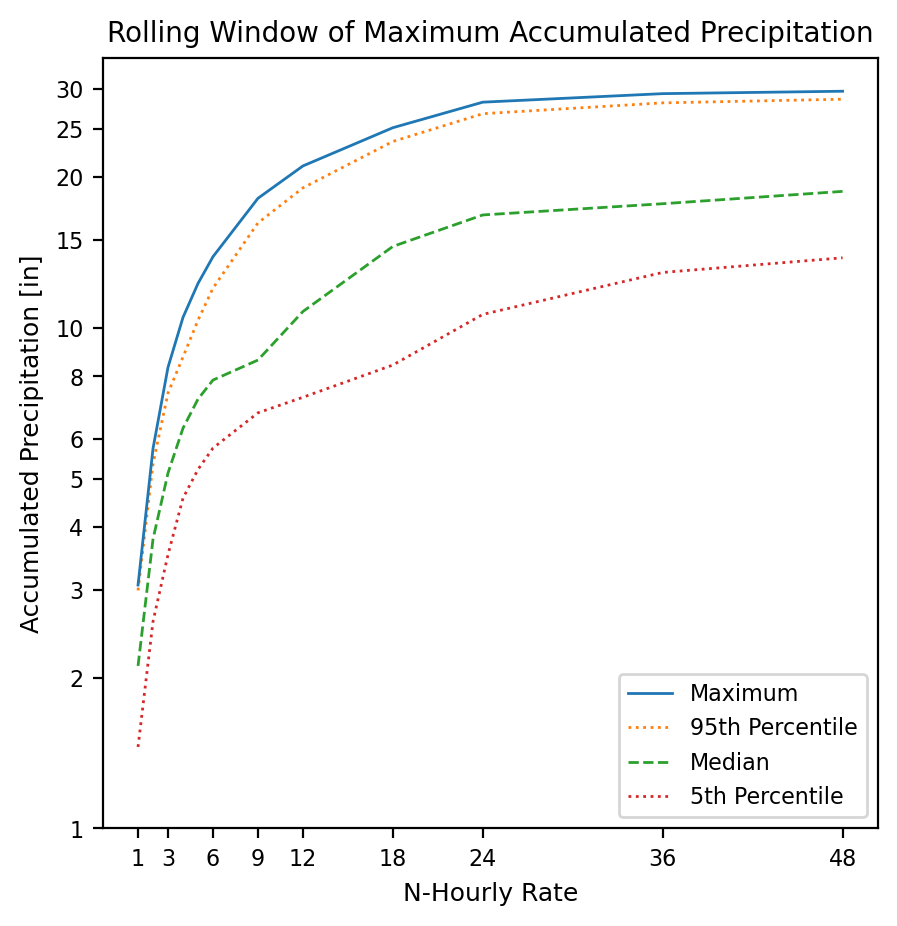

In [52]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.plot(x_axis[:-3], max_precip[:-3], label='Maximum', zorder=10, lw=1)
ax.plot(x_axis[:-3], percentile_95[:-3], ls=':', label='95th Percentile', lw=1)
ax.plot(x_axis[:-3], median[:-3], ls='--', label='Median', lw=1)
ax.plot(x_axis[:-3], percentile_5[:-3], ls=':', label='5th Percentile', lw=1)


ax.set_title('Rolling Window of Maximum Accumulated Precipitation', fontsize=10)
ax.set_xlabel('N-Hourly Rate', fontsize=9)
ax.set_ylabel('Accumulated Precipitation [in]', fontsize=9)
ax.set_yscale('log')
#ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

x_axis2 = [1, 3, 6, 9, 12, 18, 24, 36, 48, 72, 96, 120]
y_axis = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30]
ax.set_yticks(y_axis, y_axis)
ax.set_xticks(x_axis2[:-3], x_axis2[:-3])
ax.tick_params(axis='both', labelsize=8)
ax.minorticks_off()

plt.legend(fontsize=8)
plt.show()

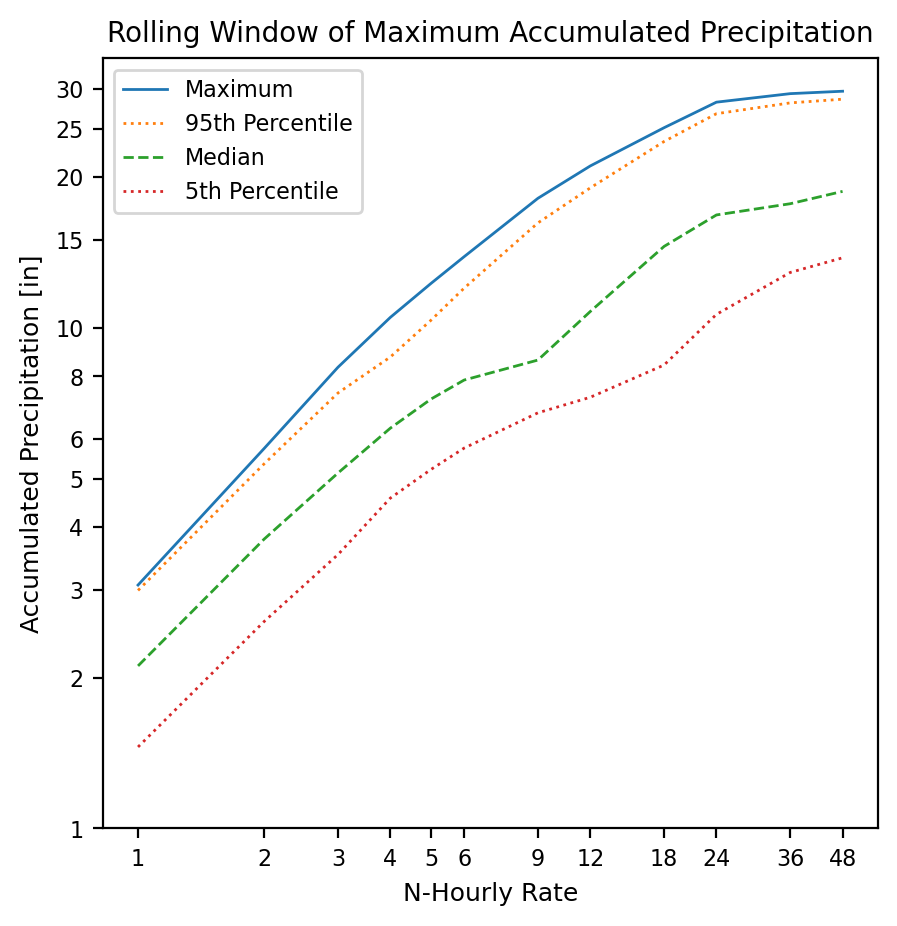

In [54]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.plot(x_axis[:-3], max_precip[:-3], label='Maximum', zorder=10, lw=1)
ax.plot(x_axis[:-3], percentile_95[:-3], ls=':', label='95th Percentile', lw=1)
ax.plot(x_axis[:-3], median[:-3], ls='--', label='Median', lw=1)
ax.plot(x_axis[:-3], percentile_5[:-3], ls=':', label='5th Percentile', lw=1)


ax.set_title('Rolling Window of Maximum Accumulated Precipitation', fontsize=10)
ax.set_xlabel('N-Hourly Rate', fontsize=9)
ax.set_ylabel('Accumulated Precipitation [in]', fontsize=9)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

x_axis2 = [1, 2, 3, 4, 5, 6, 9, 12, 18, 24, 36, 48, 72, 96, 120]
y_axis = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30]
ax.set_yticks(y_axis, y_axis)
ax.set_xticks(x_axis2[:-3], x_axis2[:-3])
ax.tick_params(axis='both', labelsize=8)
ax.minorticks_off()

plt.legend(fontsize=8)
plt.show()

In [66]:
max_rate_precip = np.amax(precip_arr, axis=1)
max_rate_precip.sort()

In [84]:
pdf_arr = np.apply_along_axis(norm().pdf, 0, max_rate_precip)
percentile_5, percentile_95 = np.percentile(precip_arr, [5, 95], axis=1)
percentile_5.sort()
percentile_95.sort()
pdf_5 = np.apply_along_axis(norm().pdf, 0, percentile_5)
pdf_95 = np.apply_along_axis(norm().pdf, 0, percentile_95)

cdf_arr = np.apply_along_axis(norm().cdf, 0, max_rate_precip)
cdf_5 = np.apply_along_axis(norm().cdf, 0, percentile_5)
cdf_95 = np.apply_along_axis(norm().cdf, 0, percentile_95)

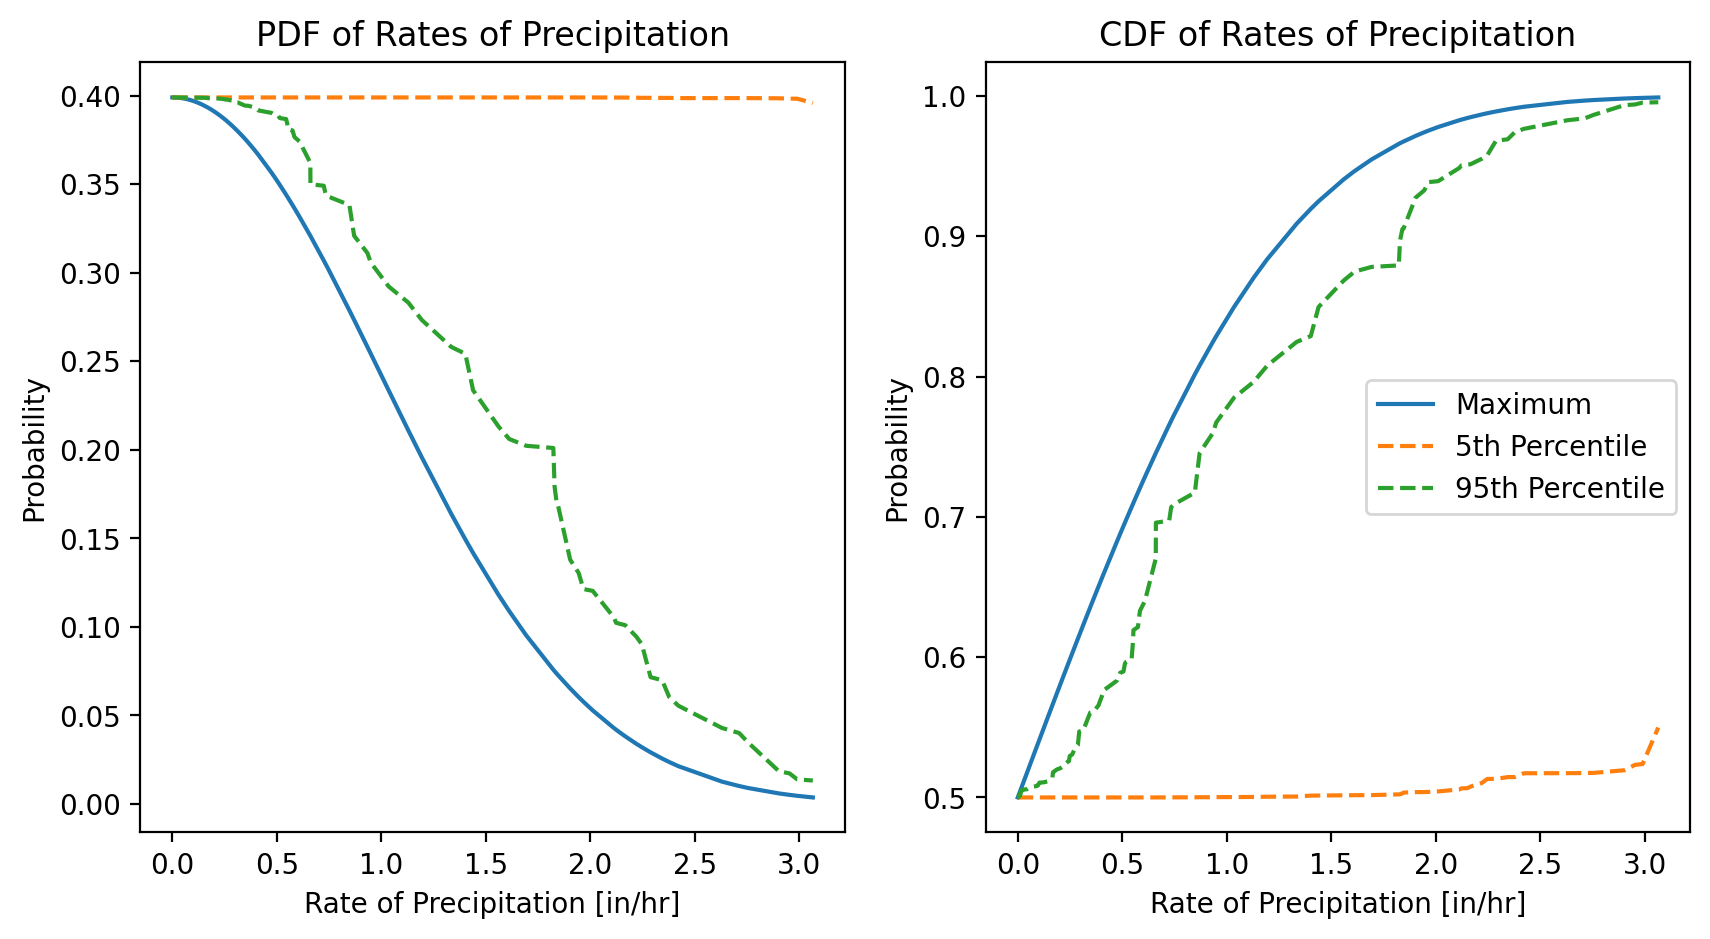

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

x_axis = np.arange(0, len(cdf_arr))
x_axis = max_rate_precip
axs[1].plot(x_axis, cdf_arr, label='Maximum')
axs[1].plot(x_axis, cdf_5, label='5th Percentile', ls='--')
axs[1].plot(x_axis, cdf_95, label='95th Percentile', ls='--')
axs[1].set_title('CDF of Rates of Precipitation')

axs[0].plot(x_axis, pdf_arr, label='Maximum')
axs[0].plot(x_axis, pdf_5, label='5th Percentile', ls='--')
axs[0].plot(x_axis, pdf_95, label='95th Percentile', ls='--')
axs[0].set_title('PDF of Rates of Precipitation')

for ax in axs.ravel():
    ax.set_ylabel('Probability')
    ax.set_xlabel('Rate of Precipitation [in/hr]')

plt.legend()
plt.show()

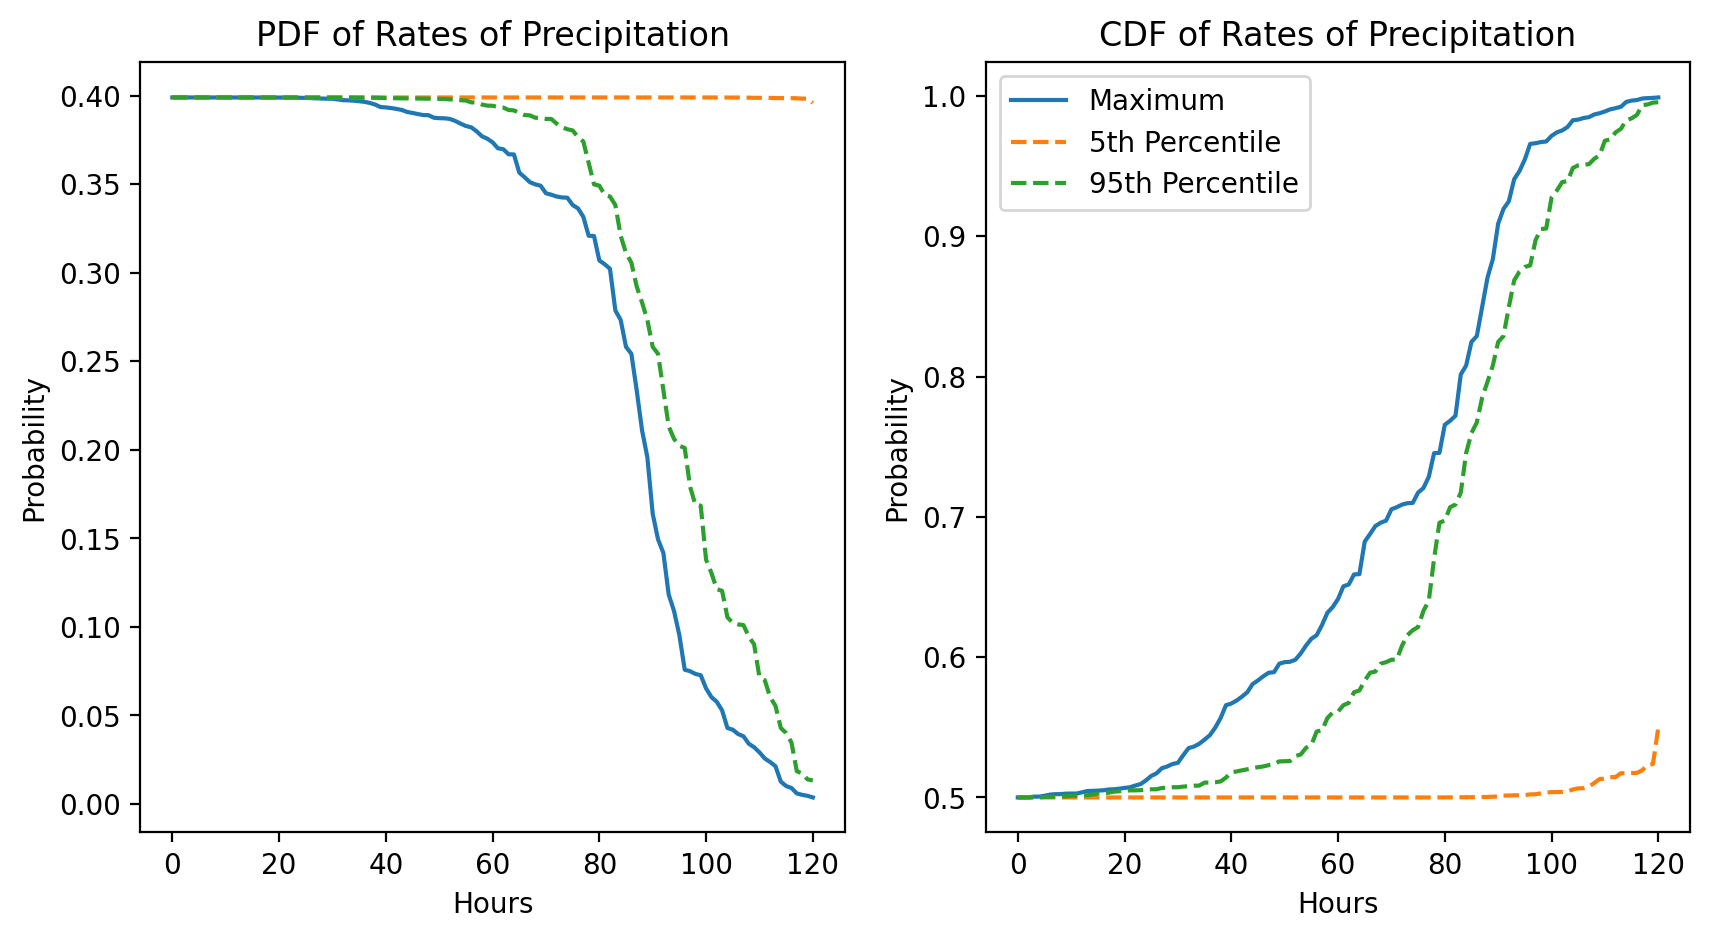

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

x_axis = np.arange(0, len(cdf_arr))
#x_axis = max_rate_precip
axs[1].plot(x_axis, cdf_arr, label='Maximum')
axs[1].plot(x_axis, cdf_5, label='5th Percentile', ls='--')
axs[1].plot(x_axis, cdf_95, label='95th Percentile', ls='--')
axs[1].set_title('CDF of Rates of Precipitation')

axs[0].plot(x_axis, pdf_arr, label='Maximum')
axs[0].plot(x_axis, pdf_5, label='5th Percentile', ls='--')
axs[0].plot(x_axis, pdf_95, label='95th Percentile', ls='--')
axs[0].set_title('PDF of Rates of Precipitation')

for ax in axs.ravel():
    ax.set_ylabel('Probability')
    ax.set_xlabel('Hours')

plt.legend()
plt.show()

In [78]:
pdf_arr = np.apply_along_axis(norm().pdf, 0, max_accum_precip)
percentile_5, percentile_95 = np.percentile(precip_window, [5, 95], axis=1)
pdf_5 = np.apply_along_axis(norm().pdf, 0, percentile_5)
pdf_95 = np.apply_along_axis(norm().pdf, 0, percentile_95)

In [79]:
cdf_arr = np.apply_along_axis(norm().cdf, 0, max_accum_precip)
percentile_5, percentile_95 = np.percentile(precip_window, [5, 95], axis=1)
cdf_5 = np.apply_along_axis(norm().cdf, 0, percentile_5)
cdf_95 = np.apply_along_axis(norm().cdf, 0, percentile_95)

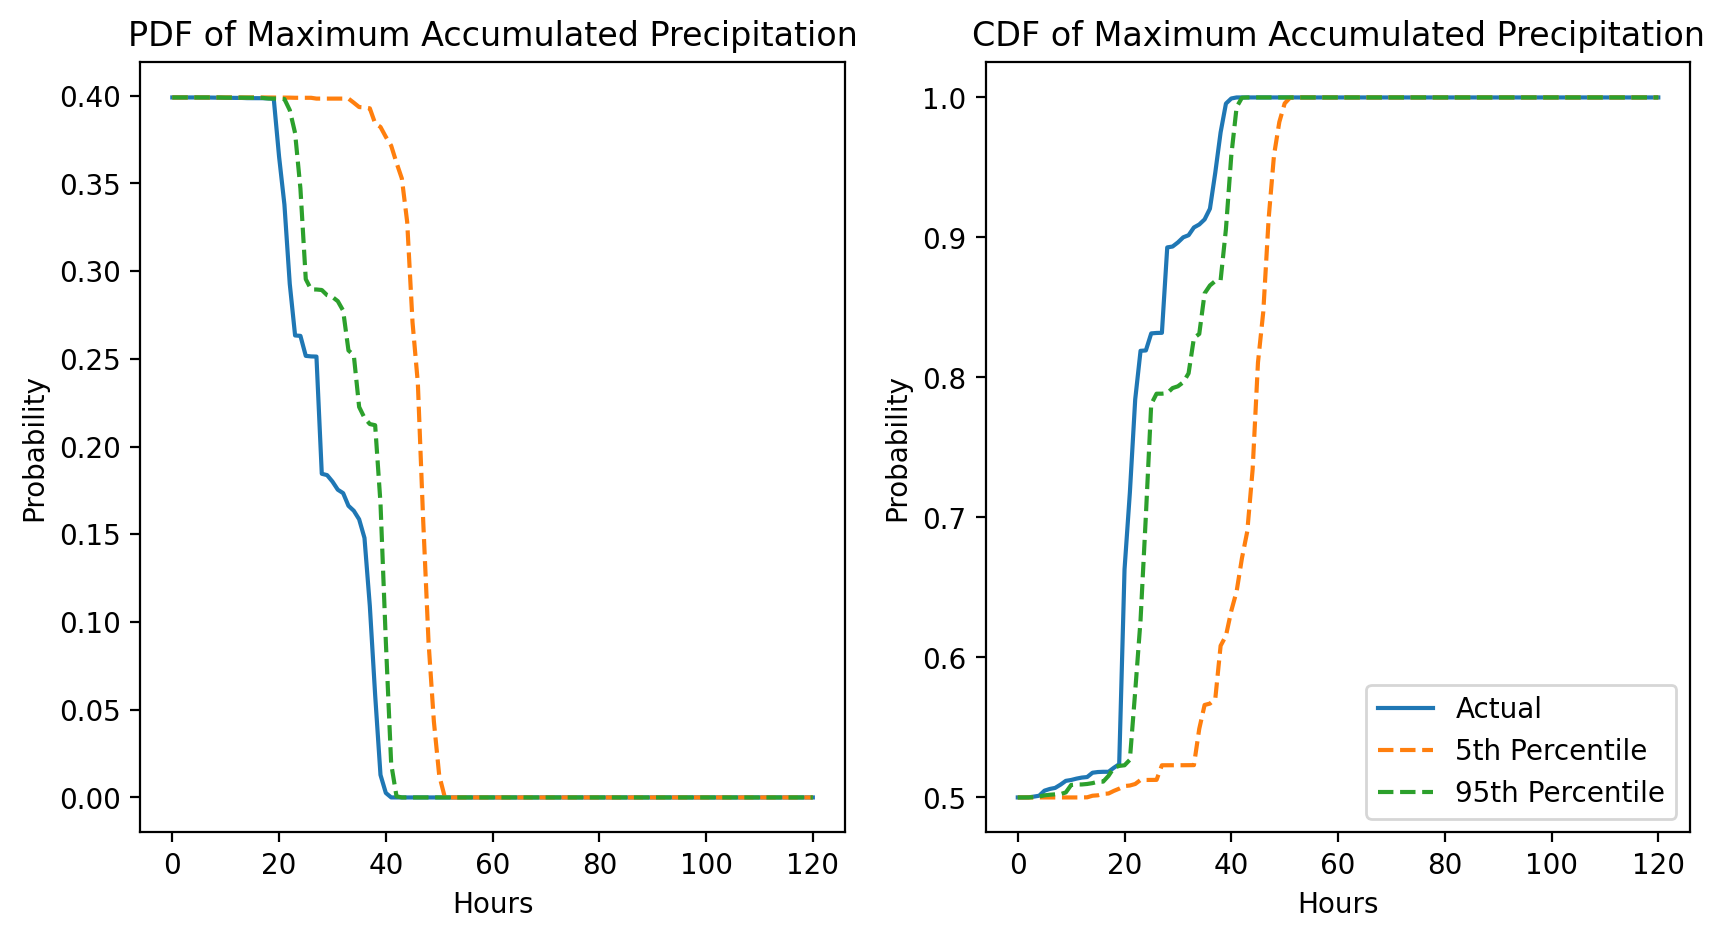

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

x_axis = np.arange(0, len(cdf_arr))
axs[1].plot(x_axis, cdf_arr, label='Actual')
axs[1].plot(x_axis, cdf_5, label='5th Percentile', ls='--')
axs[1].plot(x_axis, cdf_95, label='95th Percentile', ls='--')
axs[1].set_title('CDF of Maximum Accumulated Precipitation')

axs[0].plot(x_axis, pdf_arr, label='Actual')
axs[0].plot(x_axis, pdf_5, label='5th Percentile', ls='--')
axs[0].plot(x_axis, pdf_95, label='95th Percentile', ls='--')
axs[0].set_title('PDF of Maximum Accumulated Precipitation')

for ax in axs.ravel():
    ax.set_ylabel('Probability')
    ax.set_xlabel('Hours')

plt.legend()
plt.show()

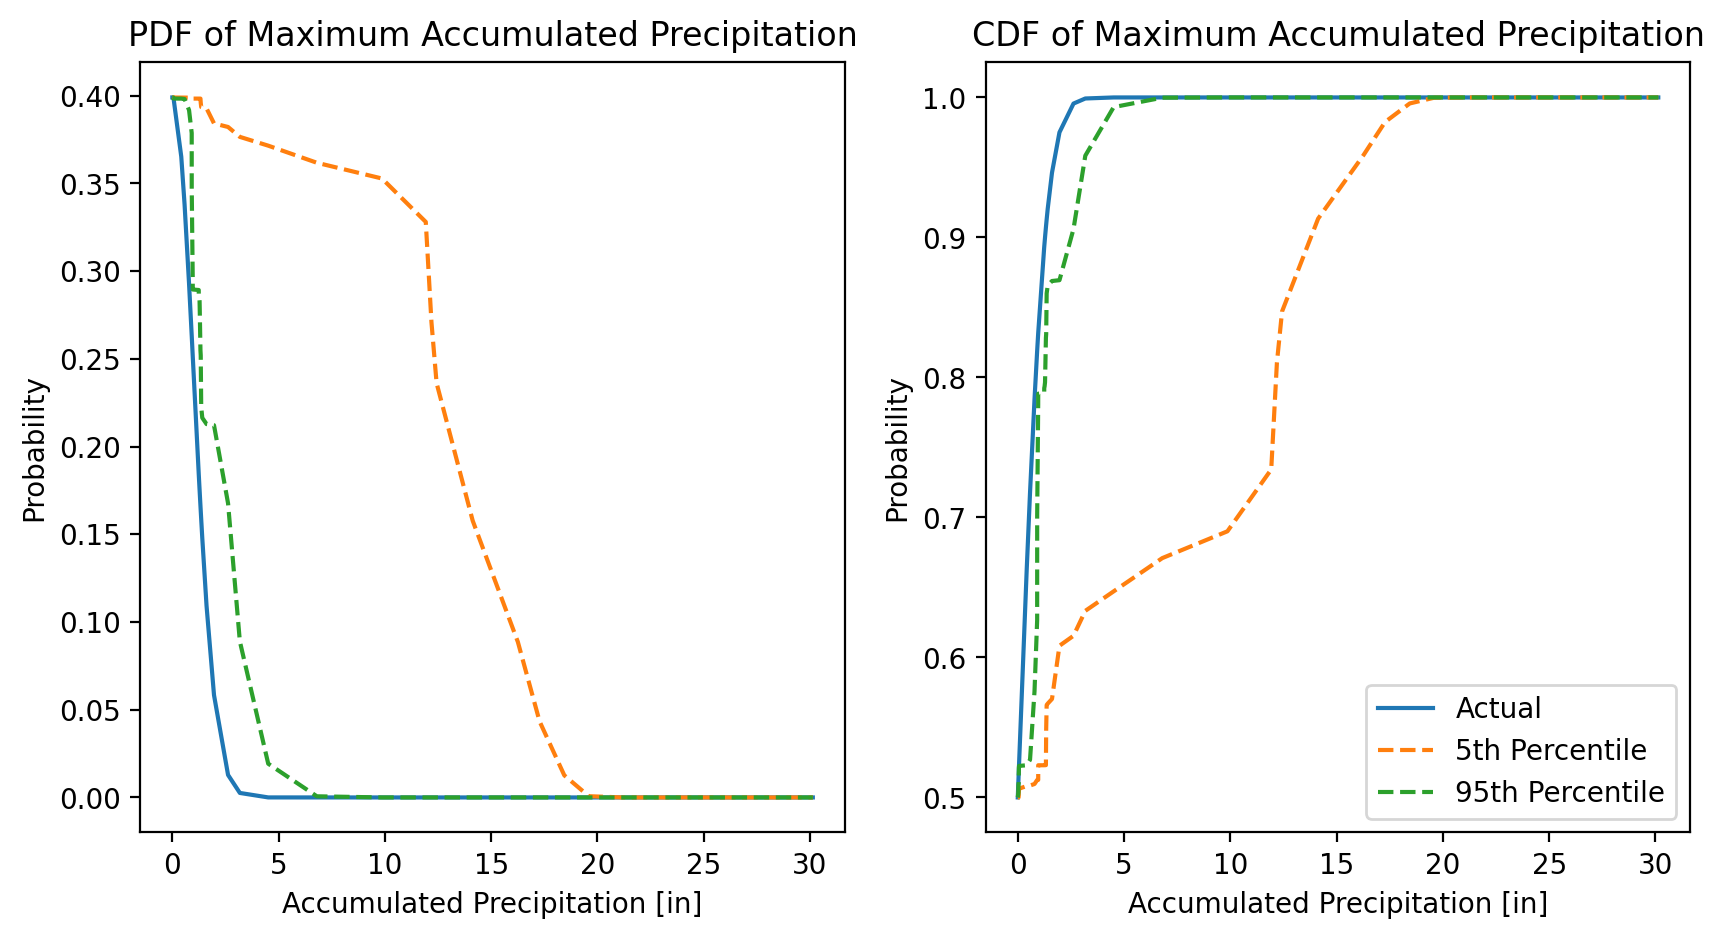

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)

x_axis = np.arange(0, len(cdf_arr))
x_axis = max_accum_precip
axs[1].plot(x_axis, cdf_arr, label='Actual')
axs[1].plot(x_axis, cdf_5, label='5th Percentile', ls='--')
axs[1].plot(x_axis, cdf_95, label='95th Percentile', ls='--')
axs[1].set_title('CDF of Maximum Accumulated Precipitation')

axs[0].plot(x_axis, pdf_arr, label='Actual')
axs[0].plot(x_axis, pdf_5, label='5th Percentile', ls='--')
axs[0].plot(x_axis, pdf_95, label='95th Percentile', ls='--')
axs[0].set_title('PDF of Maximum Accumulated Precipitation')


for ax in axs.ravel():
    ax.set_ylabel('Probability')
    ax.set_xlabel('Accumulated Precipitation [in]')

plt.legend()
plt.show()

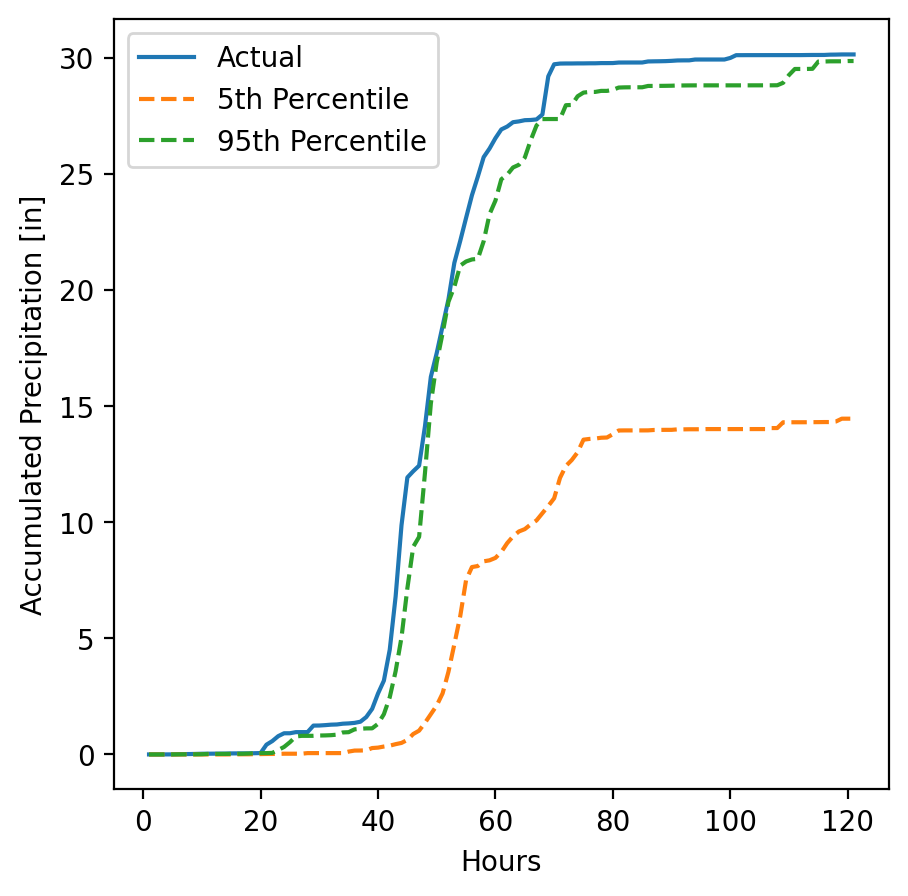

In [171]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

ax.plot(times, max_accum_precip, label='Actual')
ax.plot(times, percentile_5, label='5th Percentile', ls='--')
ax.plot(times, percentile_95, label='95th Percentile', ls='--')
ax.set_xlabel('Hours')
ax.set_ylabel('Accumulated Precipitation [in]')
plt.legend()
plt.show()

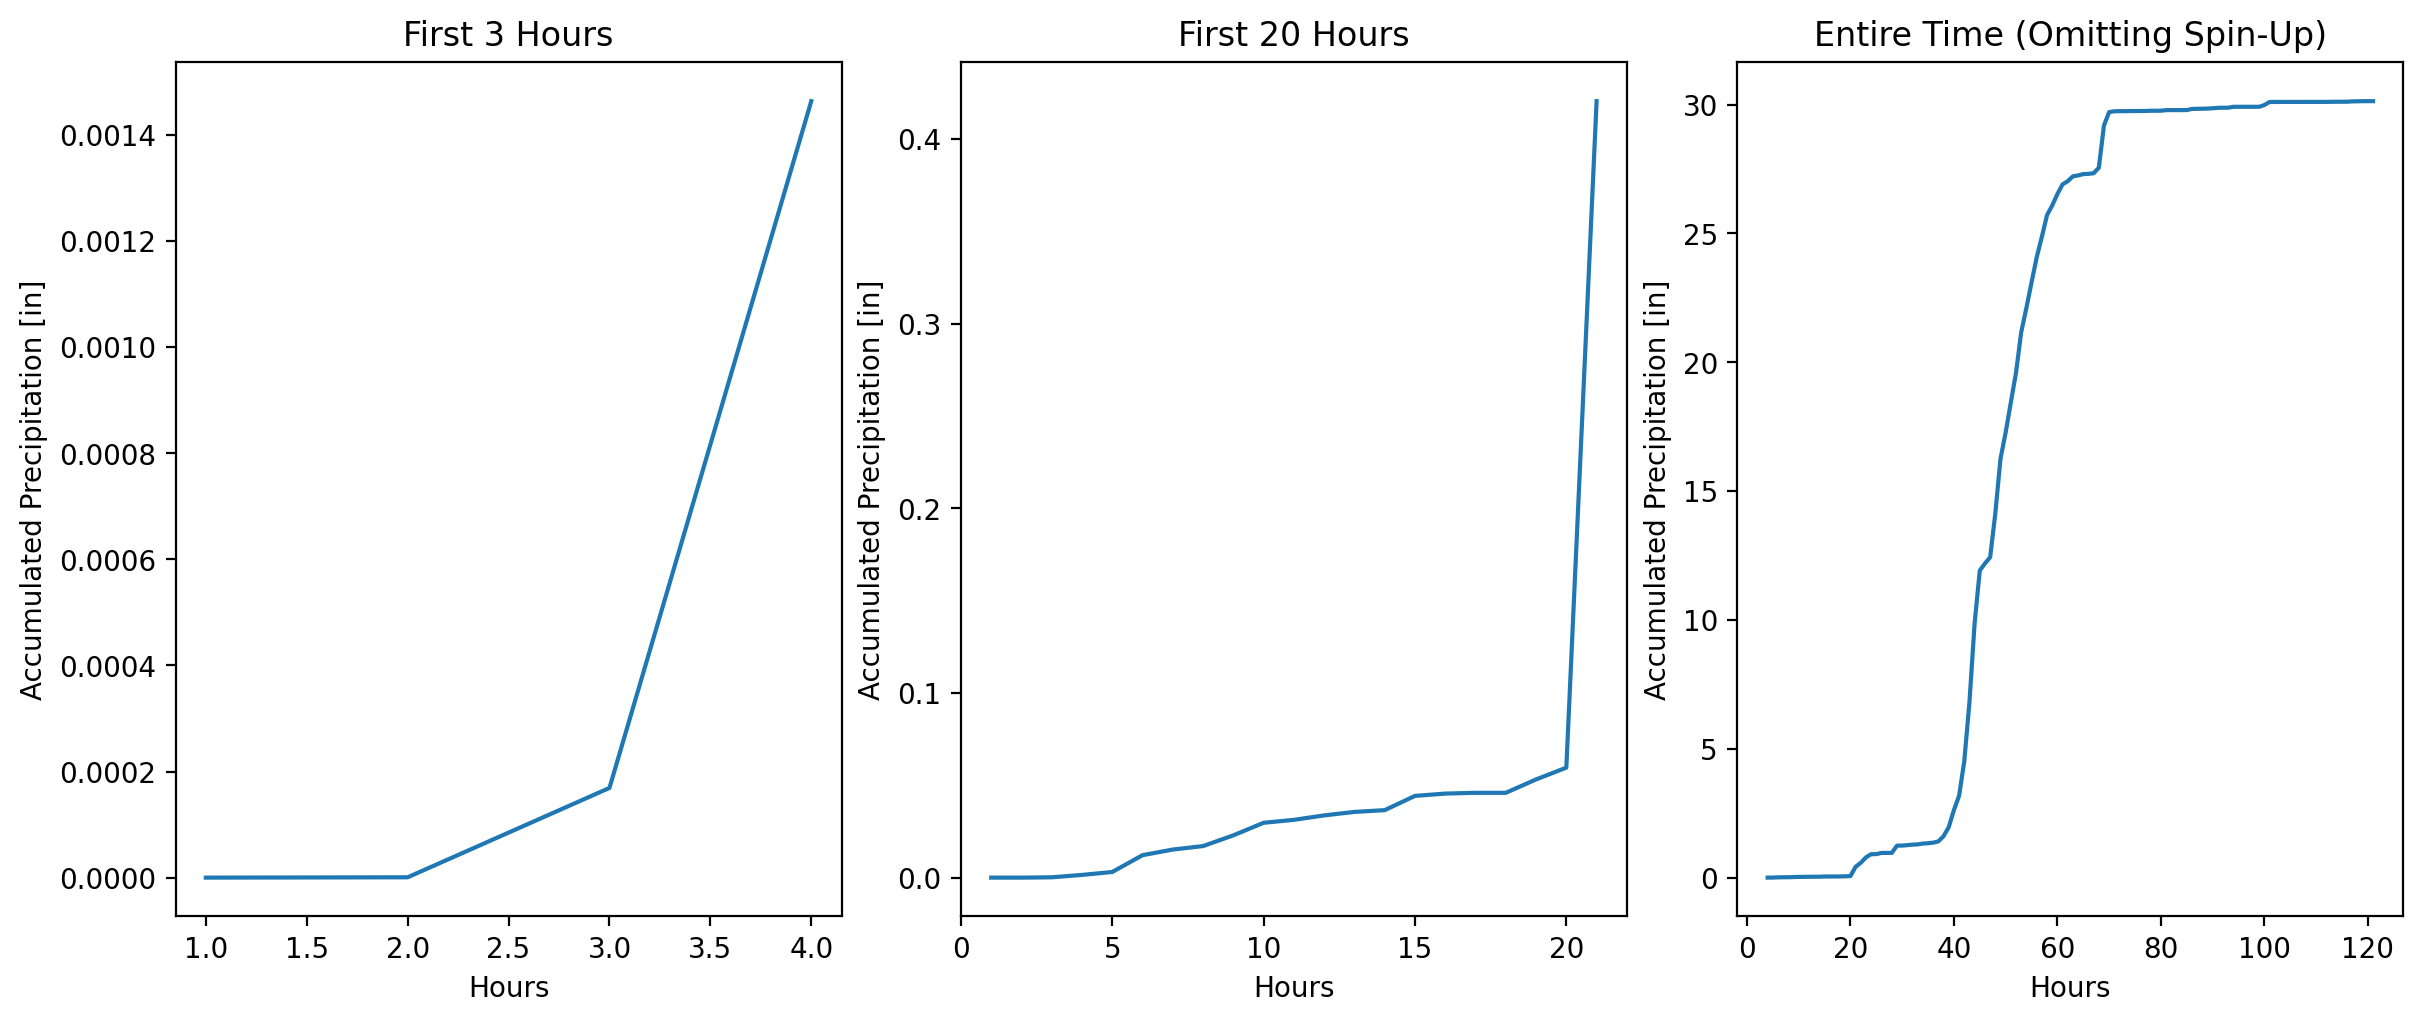

In [162]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(1, 3, figsize=(12, 5), dpi=200, layout='constrained')

times = np.linspace(0, len(precip_ts.time.values), len(precip_ts.time.values)+1)[1:]
axs[0].plot(times[0:4], max_accum_precip[0:4])
axs[0].set_title('First 3 Hours')

axs[1].plot(times[0:21], max_accum_precip[0:21])
axs[1].set_title('First 20 Hours')

axs[2].plot(times[3:], max_accum_precip[3:])
axs[2].set_title('Entire Time (Omitting Spin-Up)')


#ax.plot(times, np.amax(precip_arr, axis=1), label='Rate')
#ax.plot(times, precip_window2, label='Max Accumulation')

for ax in axs.ravel():
    ax.set_xlabel('Hours')
    ax.set_ylabel('Accumulated Precipitation [in]')
#ax.set_yscale('symlog')
#ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

#ax.ticklabel_format(axis='y', useOffset=False, style='plain')
#plt.legend()
plt.show()

In [172]:
np.amax(precip_arr, axis=1)

array([0.0000000e+00, 6.0672755e-07, 1.6857876e-04, 1.4606209e-03,
       3.0496200e-03, 1.2155136e-02, 5.8377534e-03, 1.1461989e-02,
       6.9443840e-03, 6.8067685e-03, 2.1192448e-02, 5.9522022e-03,
       6.9868932e-03, 4.9985293e-03, 9.0499502e-03, 1.2816258e-02,
       1.1781126e-02, 2.3859033e-02, 1.8167963e-02, 1.7030654e-02,
       3.9010596e-01, 4.7420263e-01, 2.1062510e-01, 5.3991520e-01,
       7.2436786e-01, 5.8440578e-01, 9.6047066e-02, 4.0962487e-01,
       3.4685838e-01, 3.8658148e-01, 1.8913880e-01, 2.2567768e-01,
       1.6552080e-01, 2.4477594e-01, 2.1821930e-01, 2.9404318e-01,
       1.2515123e-01, 2.7477419e-01, 4.8960200e-01, 6.6066796e-01,
       6.6020072e-01, 1.3342273e+00, 2.2878489e+00, 3.0641224e+00,
       2.1121895e+00, 2.1511173e+00, 2.9019449e+00, 2.7548661e+00,
       2.9891603e+00, 2.9526381e+00, 2.1662717e+00, 1.8400552e+00,
       2.0109415e+00, 2.4210138e+00, 2.6297710e+00, 1.8454553e+00,
       2.3431239e+00, 1.9668051e+00, 1.8226935e+00, 1.6115227e

In [10]:
h2cn_ds

<xarray.Dataset>
Dimensions:         (time: 21, ncol: 835586, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * ilev            (ilev) float64 4.5e+04 4.291e+04 4.085e+04 ... 249.0 0.0
  * lev             (lev) float64 4.395e+04 4.188e+04 3.984e+04 ... 476.3 124.5
  * time            (time) object 1989-08-22 00:00:00 ... 1989-08-27 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/65)
    CLDHGH          (time, ncol) float32 dask.array<chunksize=(4, 835586), meta=np.ndarray>
    CLDLOW          (time, ncol) float32 dask.array<chunksize=(4, 835586), meta=np.ndarray>
    CLDMED          (time, ncol) float32 dask.array<chunksize=(4, 835586), meta=np.ndarray>
    CLDTOT          (time, ncol) float32 dask.array<chunksize=(4, 835586), meta=np.ndarray>
    CLOUD           (time, lev, ncol) float32 dask.array<chunksize=(4, 32, 835586), meta=np.ndarray>
    FLDS            (time, ncol) float32 dask.array<chunksize=(4, 835586), meta=np.ndarray>
    ...              ...
    nsbase          (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    nscur           (time) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    nsteph          (time) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    sol_tsi         (time) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    time_bnds       (time, nbnd) object dask.array<chunksize=(4, 2), meta=np.ndarray>
    time_written    (time) |S8 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              MPAS.VR3.REF.003.storm_0236
    logname:           zarzycki
    host:              cheyenne6
    initial_file:      /glade/p/univ/upsu0032/MPAS/3km_florida/x20.835586.flo...
    topography_file:   /glade/p/univ/upsu0032/MPAS/topo/mpasa3-60-florida_gmt...
    model_doi_url:     not_set
    time_period_freq:  hour_6
    history:           Sat Nov 26 02:25:23 2022: ncks -4 -L 1 -O MPAS.VR3.REF...
    NCO:               netCDF Operators version 5.0.3 (Homepage = http://nco....

In [46]:
h3cn_ds

<xarray.Dataset>
Dimensions:       (time: 41, ncol: 835586, ilev: 33, lev: 32, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 4.5e+04 4.291e+04 4.085e+04 ... 703.5 249.0 0.0
  * lev           (lev) float64 4.395e+04 4.188e+04 3.984e+04 ... 476.3 124.5
  * time          (time) object 1989-08-22 00:00:00 ... 1989-08-27 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/51)
    CLDTOT        (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    FLUT          (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    OMEGA500      (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    OMEGA850      (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    PRECC         (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    PRECL         (time, ncol) float32 dask.array<chunksize=(8, 835586), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(8, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(8,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              MPAS.VR3.REF.003.storm_0236
    logname:           zarzycki
    host:              cheyenne6
    initial_file:      /glade/p/univ/upsu0032/MPAS/3km_florida/x20.835586.flo...
    topography_file:   /glade/p/univ/upsu0032/MPAS/topo/mpasa3-60-florida_gmt...
    model_doi_url:     not_set
    time_period_freq:  hour_3
    history:           Sat Nov 26 04:47:35 2022: ncks -4 -L 1 -O MPAS.VR3.REF...
    NCO:               netCDF Operators version 5.0.3 (Homepage = http://nco....

In [8]:
test_mpas_data

<xarray.Dataset>
Dimensions:       (time: 121, ncol: 835586, ilev: 33, lev: 32, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 4.5e+04 4.291e+04 4.085e+04 ... 703.5 249.0 0.0
  * lev           (lev) float64 4.395e+04 4.188e+04 3.984e+04 ... 476.3 124.5
  * time          (time) object 1989-08-22 00:00:00 ... 1989-08-27 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/24)
    PRECC         (time, ncol) float32 dask.array<chunksize=(24, 835586), meta=np.ndarray>
    PRECT         (time, ncol) float32 dask.array<chunksize=(24, 835586), meta=np.ndarray>
    area          (time, ncol) float64 dask.array<chunksize=(24, 835586), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...            ...
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(24,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(24, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(24,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              MPAS.VR3.REF.003.storm_0236
    logname:           zarzycki
    host:              cheyenne6
    initial_file:      /glade/p/univ/upsu0032/MPAS/3km_florida/x20.835586.flo...
    topography_file:   /glade/p/univ/upsu0032/MPAS/topo/mpasa3-60-florida_gmt...
    model_doi_url:     not_set
    time_period_freq:  hour_1
    history:           Sat Nov 26 05:04:32 2022: ncks -4 -L 1 -O MPAS.VR3.REF...
    NCO:               netCDF Operators version 5.0.3 (Homepage = http://nco....

In [16]:
test_dict = dict(name='Corrine')
test_dict

{'name': 'Corrine'}

In [17]:
isinstance(test_dict, dict)

True

# Literature:

https://geoscienceletters.springeropen.com/articles/10.1186/s40562-019-0147-x#availability-of-data-and-materials

https://github.com/pcgotan/RainIntensity/blob/master/170492.pdf